In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import shap
import seaborn as sns

In [2]:
df = pd.read_csv('adani.csv')

In [3]:
df

,timestamp,symbol,company,open,high,low,close,volume,dividends,stock_splits
0,1735237800000000000,ACC,ACC Limited,2088.100098,2101.800049,2058.000000,2065.600098,163017,0.0,0.0
1,1735237800000000000,ATGL,Adani Total Gas Limited,675.549988,685.000000,670.000000,679.299988,528352,0.0,0.0
2,1735237800000000000,AWL,Adani Wilmar Limited,320.899994,330.549988,317.200012,329.200012,2781761,0.0,0.0
3,1735237800000000000,ADANIPORTS,Adani Ports and Special Economic Zone Limited,1248.449951,1250.949951,1225.750000,1230.699951,2595142,0.0,0.0
4,1735237800000000000,ADANIENT,Adani Enterprises Limited,2415.000000,2446.149902,2390.500000,2409.949951,1982229,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
38579,1025548200000000000,ACC,ACC Limited,109.220814,110.780629,108.508723,108.779991,282660,0.0,0.0
38580,1025548200000000000,AMBUJACEM,Ambuja Cements Limited,17.586593,17.762522,17.423230,17.574026,1007265,0.0,0.0
38581,1025461800000000000,ACC,ACC Limited,108.508742,110.543281,107.830563,109.695557,659631,0.0,0.0
38582,1025461800000000000,AMBUJACEM,Ambuja Cements Limited,17.291281,17.674554,17.215883,17.586590,630442,0.0,0.0


In [4]:
# Feature Engineering: Adding Moving Average (MA50, MA200) and RSI
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=200).mean()
df['RSI'] = 100 - (100 / (1 + df['close'].pct_change().rolling(14).mean()))

In [5]:
# Fill missing values
df.fillna(method='bfill', inplace=True)

C:\Users\erzub\AppData\Local\Temp\ipykernel_15144\4146285165.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [6]:
# Add target column (next day's closing price)
df['Target'] = df['close'].shift(-1)

In [7]:
# Prepare features and target
X = df[['open', 'high', 'low', 'volume', 'MA50', 'MA200', 'RSI']]
y = df['Target']

In [8]:
# Drop NaN in target due to shifting
X = X[:-1]
y = y[:-1]

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# Predictions and evaluation
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 540.3011061404887


In [12]:
# LSTM Model
# Scaling the data for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [13]:
# Reshape for LSTM
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [14]:
# Split scaled data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)


In [15]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[1])))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

C:\Users\erzub\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0181
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0163
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0163
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0162
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0163
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0160
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0161
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0162
Epoch 9/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0162
Epoch 10/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0162
Epoch 11/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0160
Epoch 12/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0162
Epoch 13/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0164
Epoch 14/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0163
Epoch 15/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - l

In [17]:
# Predictions and evaluation
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
LSTM RMSE: 0.1276672538769505


In [18]:
# Hybrid Model (Weighted Average)
hybrid_predictions = (0.5 * rf_predictions) + (0.5 * scaler.inverse_transform(lstm_predictions).flatten())
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))
print(f"Hybrid Model RMSE: {hybrid_rmse}")

Hybrid Model RMSE: 529.1595725202687


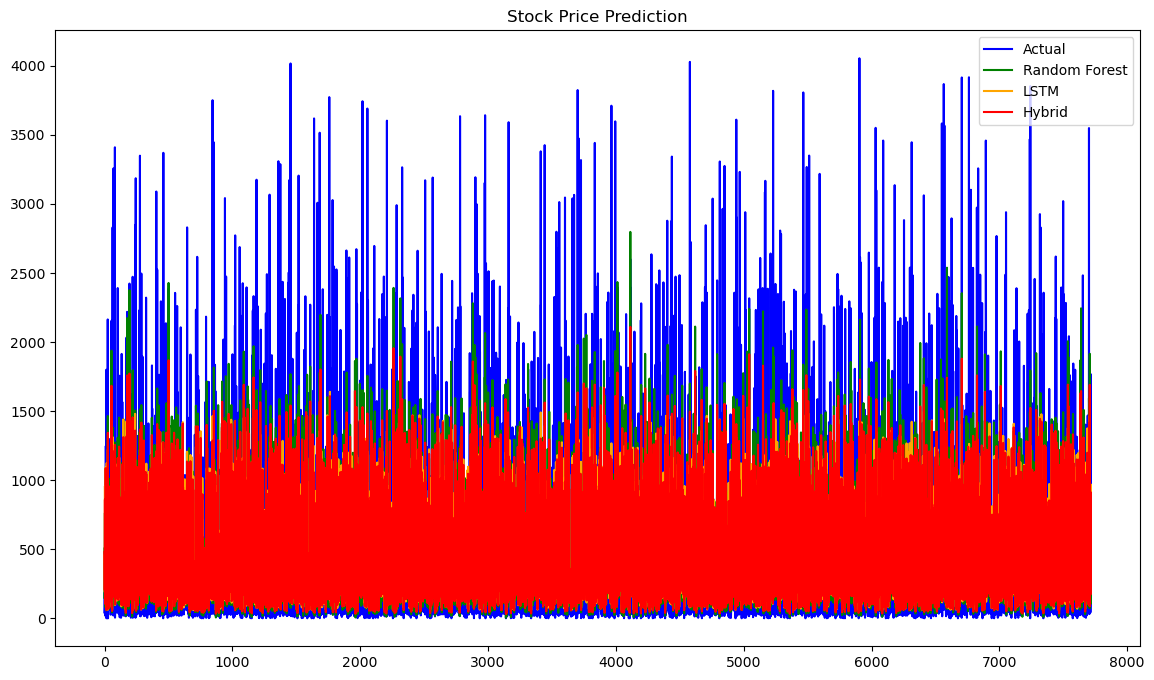

In [19]:
# Visualizations
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue')
plt.plot(range(len(rf_predictions)), rf_predictions, label='Random Forest', color='green')
plt.plot(range(len(lstm_predictions)), scaler.inverse_transform(lstm_predictions), label='LSTM', color='orange')
plt.plot(range(len(hybrid_predictions)), hybrid_predictions, label='Hybrid', color='red')
plt.legend()
plt.title("Stock Price Prediction")
plt.show()

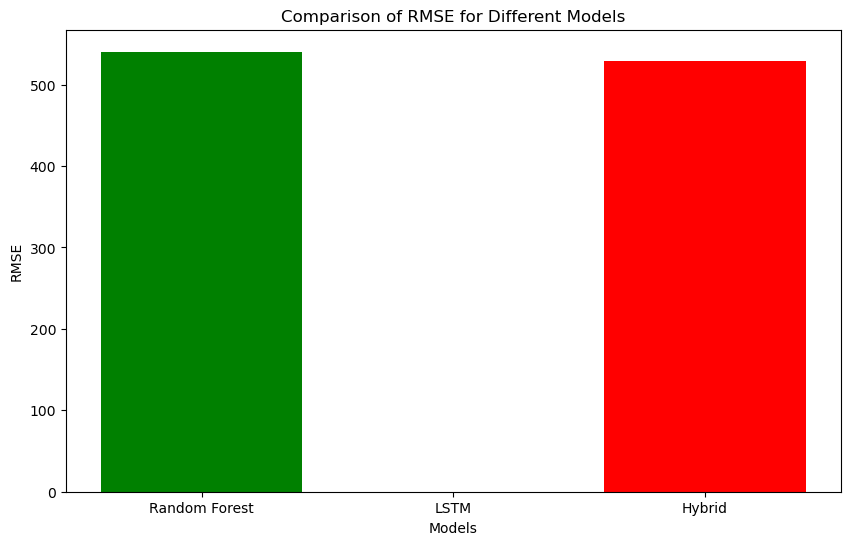

In [20]:
# Comparing RMSE values for models
models = ['Random Forest', 'LSTM', 'Hybrid']
rmse_values = [rf_rmse, lstm_rmse, hybrid_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.show()

In [21]:
# Feature Importance using SHAP
#explainer = shap.TreeExplainer(rf_model)
#shap_values = explainer.shap_values(X_test)

# Sample 500 rows from X_test for SHAP analysis
sample_size = 500
X_test_sample = X_test.sample(n=sample_size, random_state=42)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns)


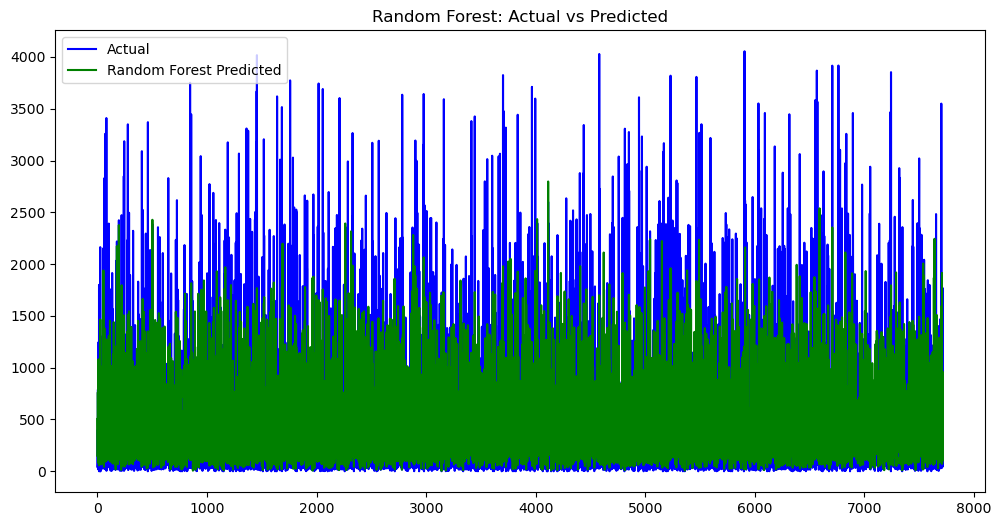

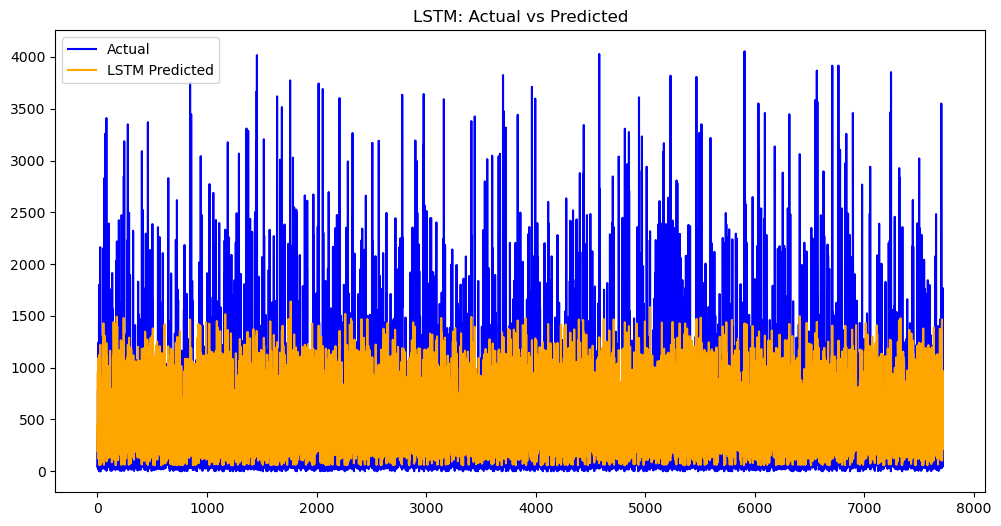

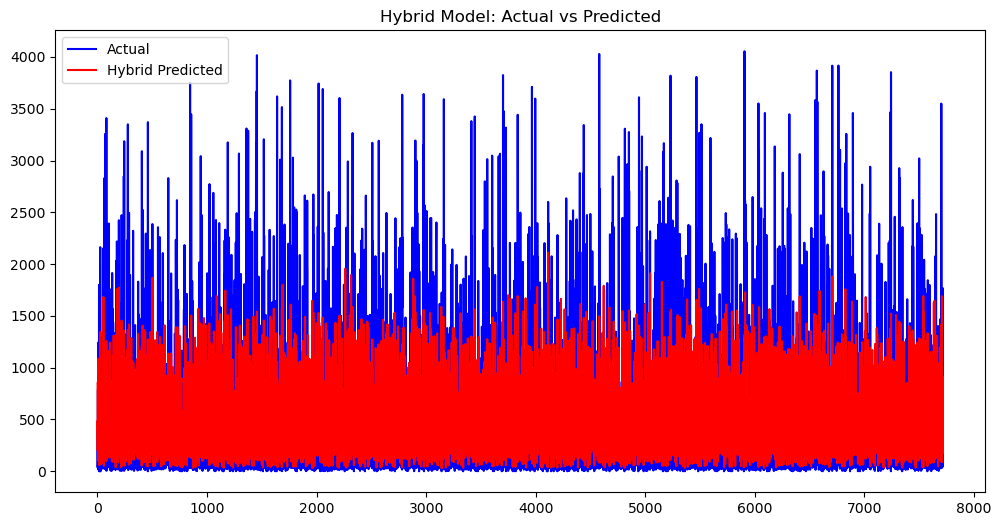

In [23]:
# Random Forest: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(rf_predictions, label='Random Forest Predicted', color='green')
plt.title("Random Forest: Actual vs Predicted")
plt.legend()
plt.show()

# LSTM: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(scaler.inverse_transform(lstm_predictions), label='LSTM Predicted', color='orange')
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.show()

# Hybrid Model: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(hybrid_predictions, label='Hybrid Predicted', color='red')
plt.title("Hybrid Model: Actual vs Predicted")
plt.legend()
plt.show()


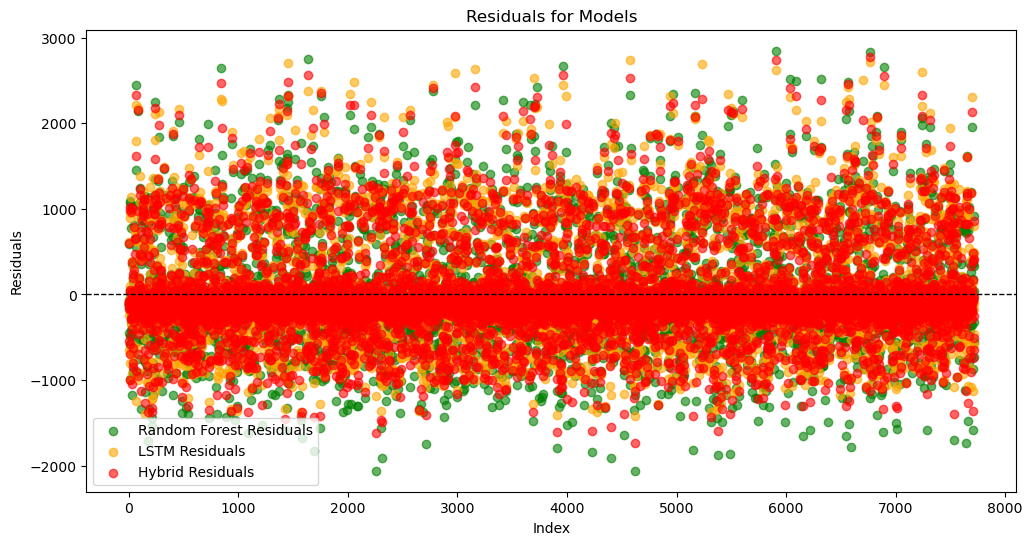

In [24]:
# Calculate residuals for each model
rf_residuals = y_test - rf_predictions
lstm_residuals = y_test.values - scaler.inverse_transform(lstm_predictions).flatten()
hybrid_residuals = y_test - hybrid_predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(range(len(rf_residuals)), rf_residuals, alpha=0.6, label='Random Forest Residuals', color='green')
plt.scatter(range(len(lstm_residuals)), lstm_residuals, alpha=0.6, label='LSTM Residuals', color='orange')
plt.scatter(range(len(hybrid_residuals)), hybrid_residuals, alpha=0.6, label='Hybrid Residuals', color='red')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title("Residuals for Models")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.legend()
plt.show()


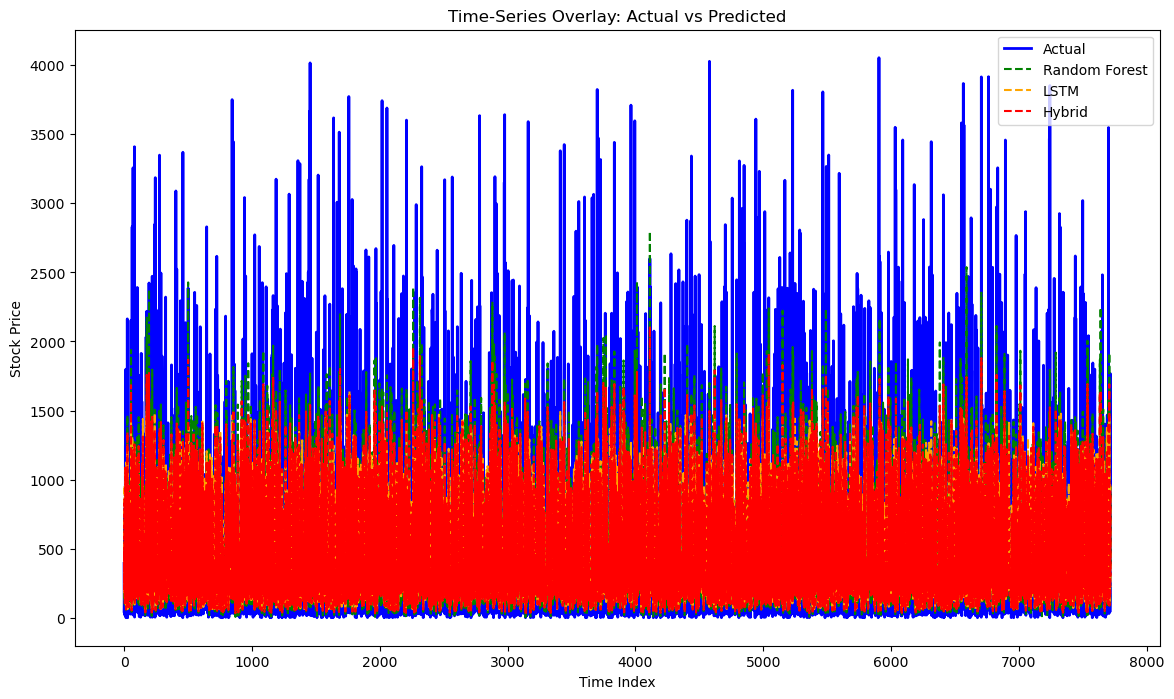

In [25]:
#Time-Series Overlay Plot for Predictions
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test.values, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(rf_predictions)), rf_predictions, label='Random Forest', color='green', linestyle='dashed')
plt.plot(range(len(lstm_predictions)), scaler.inverse_transform(lstm_predictions), label='LSTM', color='orange', linestyle='dashed')
plt.plot(range(len(hybrid_predictions)), hybrid_predictions, label='Hybrid', color='red', linestyle='dashed')
plt.title("Time-Series Overlay: Actual vs Predicted")
plt.legend()
plt.xlabel("Time Index")
plt.ylabel("Stock Price")
plt.show()


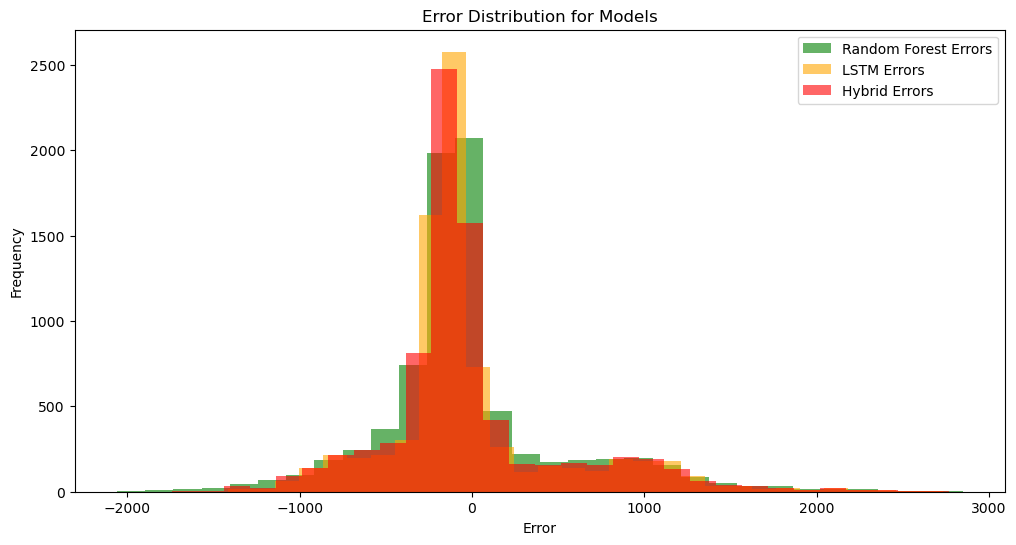

In [26]:
# Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(rf_residuals, bins=30, alpha=0.6, label='Random Forest Errors', color='green')
plt.hist(lstm_residuals, bins=30, alpha=0.6, label='LSTM Errors', color='orange')
plt.hist(hybrid_residuals, bins=30, alpha=0.6, label='Hybrid Errors', color='red')
plt.title("Error Distribution for Models")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Aggregate SHAP values to show average importance
shap_importance = np.abs(shap_values).mean(axis=0)
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_importance, color='teal')
plt.title("Feature Importance (SHAP)")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


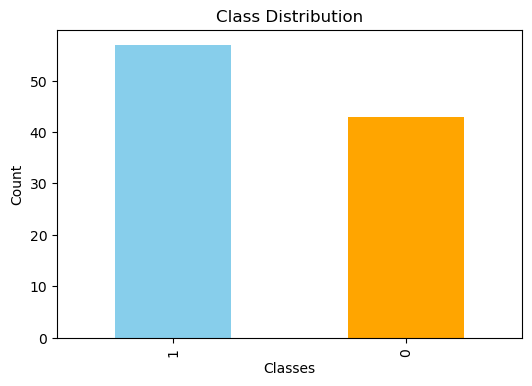

ValueError: The 'color' keyword argument must have one color per dataset, but 1 datasets and 2 colors were provided

<Figure size 1000x400 with 0 Axes>

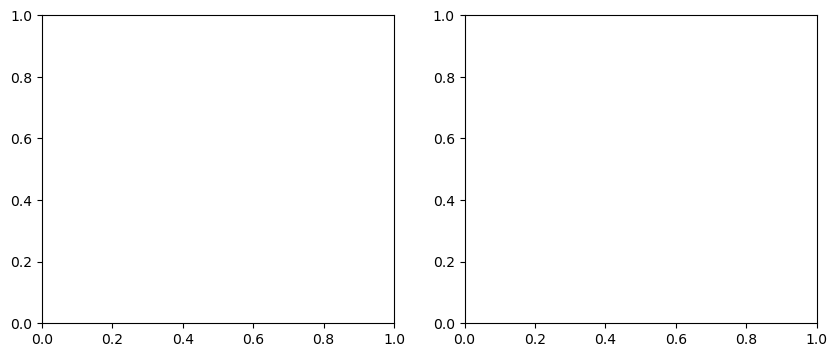

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# Assuming your dataset is loaded into 'df'
# Replace 'target_column' with your actual target column name

# Example Dataset
np.random.seed(42)
df = pd.DataFrame({
    'Feature1': np.random.randn(100),
    'Feature2': np.random.randn(100),
    'Target': np.random.choice([0, 1], size=100)
})

# 1. Bar Plot for Class Distribution
plt.figure(figsize=(6, 4))
df['Target'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# 2. Histogram of Features
plt.figure(figsize=(10, 4))
df[['Feature1', 'Feature2']].hist(bins=20, figsize=(10, 4), color=['blue', 'green'])
plt.suptitle('Feature Distribution')
plt.show()

# 3. Heatmap for Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 5. ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 6. Feature Importance (For Tree-Based Models)
importances = model.feature_importances_
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=X.columns, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# 7. Scatter Plot for Predictions (Regression Example)
y_pred_regression = model.predict(X_test)  # For regression example
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
